**FORECASTING INSURANCE CROSS SELL OPPORTUNITIES**

The client is an insurance company that has provided health insurance to its customers, now they need your help to build a predictive model that can predict whether past year's policyholders might also be interested in purchasing insurance for your vehicle.

The dataset is composed of the following properties:

id: buyer's unique id; Gender: gender of the buyer; Age: age of the buyer; Driving_License: 1 if the user has a driving license, 0 otherwise; Region_Code: unique code of the buyer's region; Previously_Insured: 1 if the user already has an insured vehicle, 0 otherwise; Vehicle_Age: age of the vehicle; Vehicle_Damage: 1 if the user has damaged the vehicle in the past, 0 otherwise; Annual_Premium: the amount that the user must pay as a premium during the year; Policy_Sales_Channel: anonymized code of the channel used for the proposal (e.g. by email, by telephone, in person, etc...); Vintage: number of days since the user has been a customer of the company; Response: 1 if the buyer responded positively to the sales proposal, 0 otherwise.

The goal of the model is to predict the value of Response.

**Import libraries and dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from scipy.stats import chi2_contingency

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv', index_col=0)
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


**Exploratory Data Analysis & Feature Selection**

In [ ]:
X_cont = df[['Age', 'Annual_Premium', 'Vintage', 'Response']]

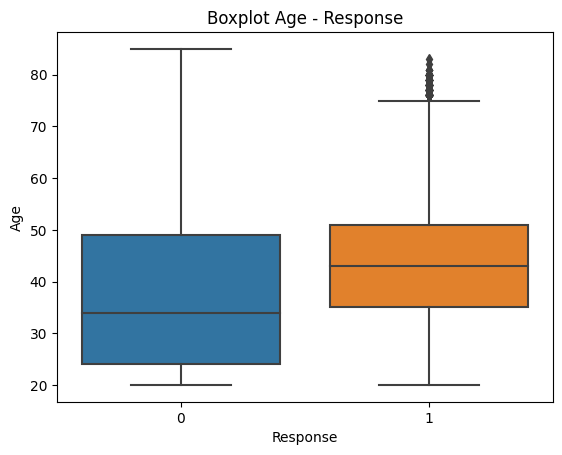

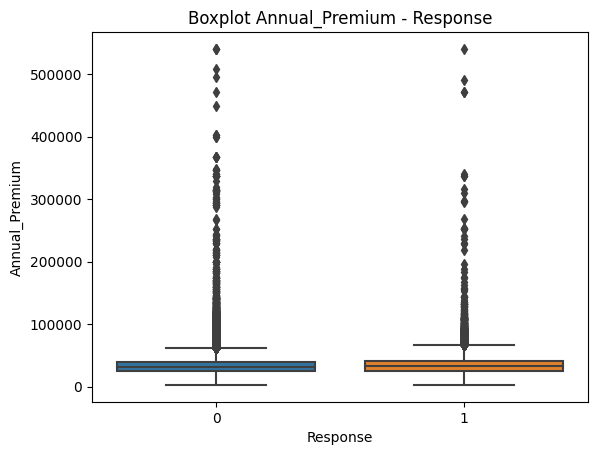

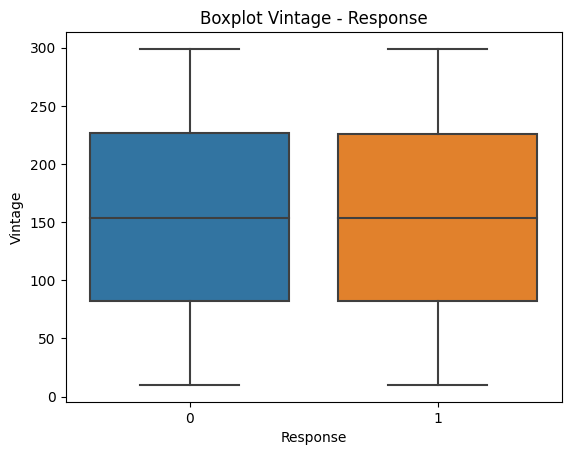

In [ ]:
for i in X_cont:
  if i != 'Response':
    plt.title(f'Boxplot {i} - Response')
    sns.boxplot(x='Response', y=i, data=X_cont)
    plt.show()

From the visualizations it is clear that the "Annual_Premium" and "Vintage" variables haven't a relationship with the target variable. *Therefore they can be excluded from the model*. Instead it can be seen that the decision to take out the insurance policy is linked to the age of the customer. Despite this, it cannot be said that age has a direct influence on the decision as it could be assumed that in reality it is income (associated with greater work experience and therefore age) that drives the choice.

In [ ]:
X_cat = df[['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']]

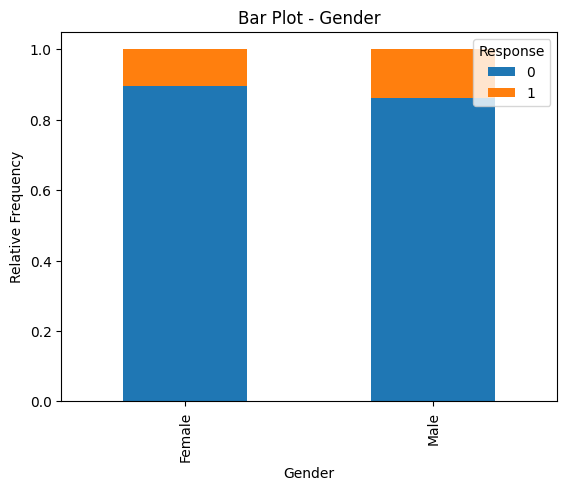

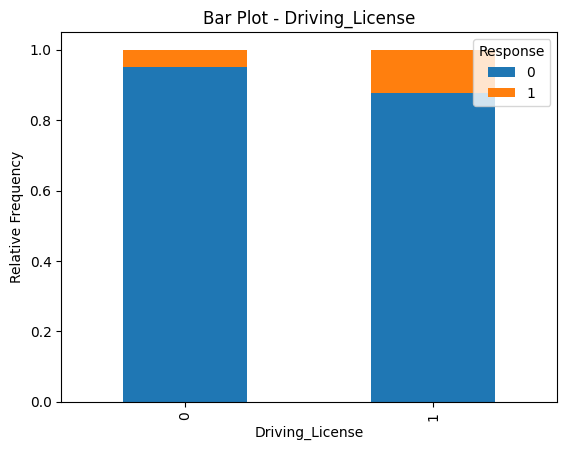

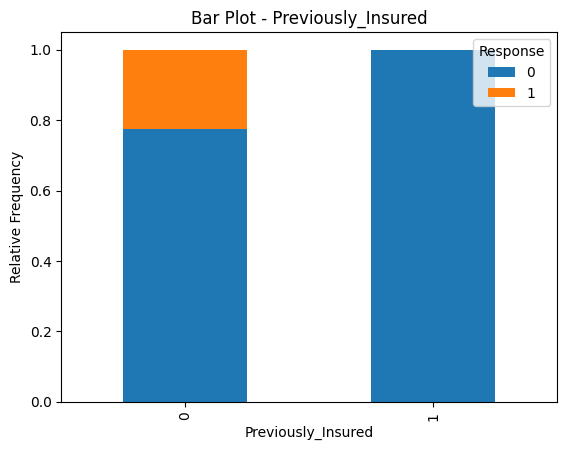

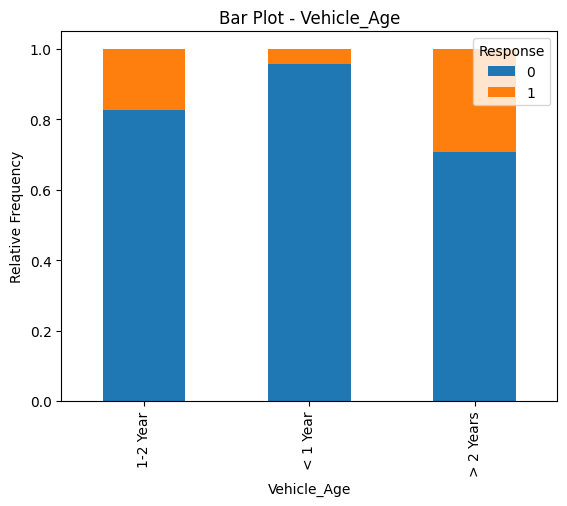

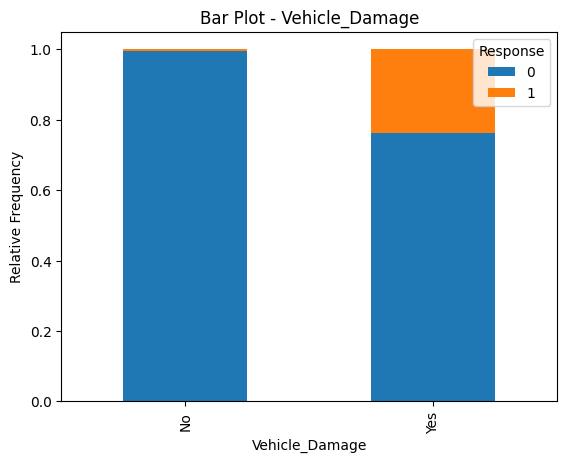

In [ ]:
for i in X_cat.columns:
    if i != 'Response':
        plot_data = X_cat[[i, 'Response']].copy()
        relative_frequencies = plot_data.groupby(i)['Response'].value_counts(normalize=True).unstack()
        relative_frequencies.plot(kind='bar', stacked=True)
        plt.title(f'Bar Plot - {i}')
        plt.xlabel(i)
        plt.ylabel('Relative Frequency')
        plt.legend(title='Response', loc='upper right')
        plt.show()

A relationship is highlighted between all the qualitative variables previously displayed and the target variable.

In [ ]:
X_catmltlvl = df[['Region_Code', 'Policy_Sales_Channel', 'Response']]
for i in X_catmltlvl.columns:
  if i != 'Response':
    print(f'chi2 test between {i} and Response')
    contingency_table = pd.crosstab(X_catmltlvl['Response'], X_catmltlvl['Region_Code'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    print(f'p-value: {p_val}')
    print('----------')

chi2 test between Region_Code and Response
p-value: 0.0
----------
chi2 test between Policy_Sales_Channel and Response
p-value: 0.0
----------


Since the two variables are qualitative nominal and have many levels it may be difficult to include them in the model. So, first of all, I've verified that there was indeed a relationship between the two variables with the target one. Both relationships were found to be significant.

**Data preprocessing**


In [ ]:
print(df['Gender'].value_counts())
map_gen = {'Male':1, 'Female':0}
df['Gender'] = df['Gender'].map(map_gen)

Male      206089
Female    175020
Name: Gender, dtype: int64


In [ ]:
print(df['Vehicle_Age'].value_counts())
map_vehage = {'< 1 Year':1, '1-2 Year':2, '> 2 Years':3}
df['Vehicle_Age'] = df['Vehicle_Age'].map(map_vehage)

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64


In [ ]:
print(df['Vehicle_Damage'].value_counts())
map_vehdam = {'Yes':1, 'No':0}
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(map_vehdam)

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64


In [ ]:
for i in X_catmltlvl.columns:
  if i != 'Response':
    rel_frq = df[i].value_counts(normalize=True)
    index = rel_frq[rel_frq > 0.1].index
    df[i] = df[i].apply(lambda x: 'Other' if x not in index else x)
df = pd.get_dummies(df, columns = ['Region_Code', 'Policy_Sales_Channel'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 1 to 381109
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      381109 non-null  int64  
 1   Age                         381109 non-null  int64  
 2   Driving_License             381109 non-null  int64  
 3   Previously_Insured          381109 non-null  int64  
 4   Vehicle_Age                 381109 non-null  int64  
 5   Vehicle_Damage              381109 non-null  int64  
 6   Annual_Premium              381109 non-null  float64
 7   Vintage                     381109 non-null  int64  
 8   Response                    381109 non-null  int64  
 9   Region_Code_28.0            381109 non-null  uint8  
 10  Region_Code_Other           381109 non-null  uint8  
 11  Policy_Sales_Channel_26.0   381109 non-null  uint8  
 12  Policy_Sales_Channel_124.0  381109 non-null  uint8  
 13  Policy_Sales_C

Performing OneHotEncoding on these two variables would have been complicated from an interpretative and computational point of view.
I have enclosed all levels with relative frequency less than 10% in a new "other" level. Then I did the encoding.

**Model selection**

I will use the hold-out method to check for overfitting because I am working on a large dataset so cross validation is not needed.  It would just make the script computationally complex.

I first check whether the classes of the targetv variable are balanced

In [ ]:
df['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

Since the classes are unbalanced I will have to specify it as a logistic regression parameter or use oversampling/undersampling methods.

***class_weight = 'balanced'***

In [ ]:
X = df.drop(['Response','Annual_Premium','Vintage'], axis = 1)
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)
ss = StandardScaler()
X_train[['Age']]  = ss.fit_transform(X_train[['Age']])
X_train = X_train.values
X_test[['Age']] = ss.transform(X_test[['Age']])
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Report train
              precision    recall  f1-score   support

           0       0.99      0.61      0.75    267700
           1       0.25      0.96      0.40     37187

    accuracy                           0.65    304887
   macro avg       0.62      0.78      0.58    304887
weighted avg       0.90      0.65      0.71    304887

Report test
              precision    recall  f1-score   support

           0       1.00      0.58      0.74     66699
           1       0.25      0.98      0.40      9523

    accuracy                           0.63     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.63      0.69     76222



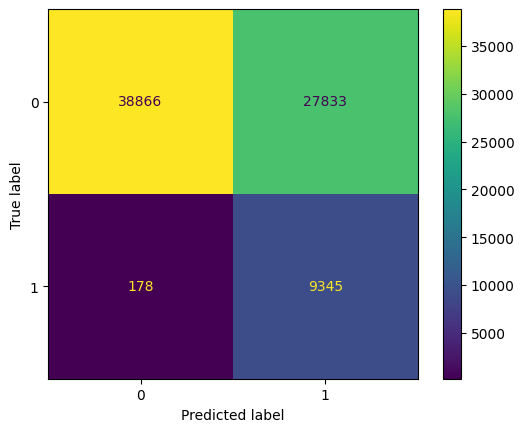

In [ ]:
lr_bln = LogisticRegression(class_weight = 'balanced', random_state=42)
lr_bln.fit(X_train, y_train)
y_train_pred = lr_bln.predict(X_train)
print('Report train')
print(classification_report(y_train, y_train_pred))

y_test_pred = np.where(lr_bln.predict_proba(X_test)[:,1]>0.3, 1, 0)
print('Report test')
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

***oversampling***

In [ ]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(X,y, test_size= 0.2, random_state=42)
smote = SMOTE()
X_train_ov, y_train_ov = smote.fit_resample(X_train_ov, y_train_ov)
X_train_ov[['Age']]  = ss.fit_transform(X_train_ov[['Age']])
X_train_ov = X_train_ov.values
X_test_ov[['Age']] = ss.transform(X_test_ov[['Age']])
X_test_ov = X_test_ov.values
y_train_ov = y_train_ov.values
y_test_ov = y_test_ov.values

Report train
              precision    recall  f1-score   support

           0       0.94      0.61      0.74    267700
           1       0.71      0.96      0.82    267700

    accuracy                           0.78    535400
   macro avg       0.82      0.78      0.78    535400
weighted avg       0.82      0.78      0.78    535400

Report test
              precision    recall  f1-score   support

           0       1.00      0.58      0.73     66699
           1       0.25      0.98      0.40      9523

    accuracy                           0.63     76222
   macro avg       0.62      0.78      0.56     76222
weighted avg       0.90      0.63      0.69     76222



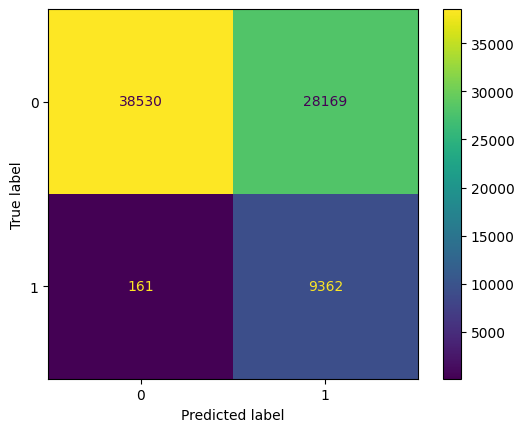

In [ ]:
lr_ov = LogisticRegression(max_iter=500, penalty= 'l1', solver= 'liblinear', C=0.1, random_state=42)
lr_ov.fit(X_train_ov, y_train_ov)
y_train_pred_ov = lr_ov.predict(X_train_ov)
print('Report train')
print(classification_report(y_train_ov, y_train_pred_ov))

y_test_pred_ov = np.where(lr_ov.predict_proba(X_test_ov)[:,1]>0.3, 1, 0)
print('Report test')
print(classification_report(y_test_ov, y_test_pred_ov))
cm_ov = confusion_matrix(y_test_ov, y_test_pred_ov)
cm_display_ov = ConfusionMatrixDisplay(cm_ov).plot()

***undersampling***

In [ ]:
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X,y, test_size= 0.2, random_state=42)
rnd = RandomUnderSampler()
X_train_un, y_train_un = rnd.fit_resample(X_train_un, y_train_un)
X_train_un[['Age']]  = ss.fit_transform(X_train_un[['Age']])
X_train_un = X_train_un.values
X_test_un[['Age']] = ss.transform(X_test_un[['Age']])
X_test_un = X_test_un.values
y_train_un = y_train_un.values
y_test_un = y_test_un.values

Report train
              precision    recall  f1-score   support

           0       0.94      0.60      0.73     37187
           1       0.71      0.97      0.82     37187

    accuracy                           0.78     74374
   macro avg       0.83      0.78      0.77     74374
weighted avg       0.83      0.78      0.77     74374

Report test
              precision    recall  f1-score   support

           0       1.00      0.58      0.73     66699
           1       0.25      0.98      0.40      9523

    accuracy                           0.63     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.63      0.69     76222



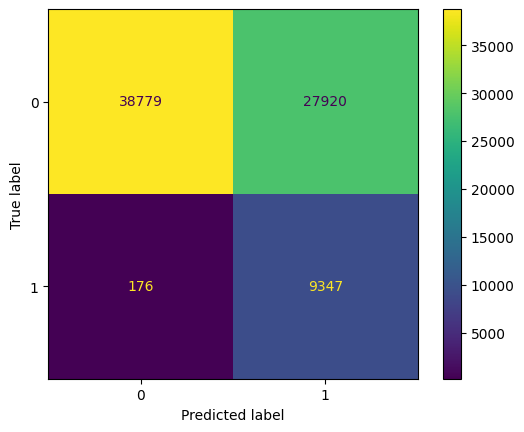

In [ ]:
lr_un = LogisticRegression(max_iter=500, penalty='l1', solver='liblinear', C=0.1, random_state=42)
lr_un.fit(X_train_un, y_train_un)
y_train_pred_un = lr_un.predict(X_train_un)
print('Report train')
print(classification_report(y_train_un, y_train_pred_un))

y_test_pred_un = np.where(lr_un.predict_proba(X_test_un)[:,1]>0.3, 1, 0)
print('Report test')
print(classification_report(y_test_un, y_test_pred_un))
cm_un = confusion_matrix(y_test_un, y_test_pred_un)
cm_display_un = ConfusionMatrixDisplay(cm_un).plot()

Selected model:

First of all I have to decide on which metrics to base the choice of the model. The company is interested in predicting which customers can take out a new policy.  Why doesn't it contact everyone?  Maybe the company can send an email to everyone while, in particular, looking for direct contact with those who the algorithm predicts will accept the offer. In This way the company can use its resources more efficiently. So I consider recall on 1 as metrics because it is important to get in touch with those who are interested to increase profits but at the same time precision on 1 is important in order not to waste too many resources.

The models are more or less equivalent, so with the same metrics I choose the simplest model, i.e. the one with the parameter class_weight = 'balanced, with the threshold = 0.3.

**Predictions**

In [ ]:
X_mod = X
X_mod[['Age']] = ss.fit_transform(X_mod[['Age']])
X_mod = X_mod.values
y_mod = y.values
lr_bln.fit(X_mod,y_mod)

LogisticRegression(class_weight='balanced', random_state=42)

In [ ]:
pred = pd.read_csv('/content/drive/MyDrive/test.csv', index_col=0)

map_gen = {'Male':1, 'Female':0}
pred['Gender'] = pred['Gender'].map(map_gen)

map_vehage = {'< 1 Year':1, '1-2 Year':2, '> 2 Years':3}
pred['Vehicle_Age'] = pred['Vehicle_Age'].map(map_vehage)

map_vehdam = {'Yes':1, 'No':0}
pred['Vehicle_Damage'] = pred['Vehicle_Damage'].map(map_vehdam)

X_catmltlvl = pred[['Region_Code', 'Policy_Sales_Channel']]
for i in X_catmltlvl.columns:
  if i != 'Response':
    rel_frq = pred[i].value_counts(normalize=True)
    index = rel_frq[rel_frq > 0.1].index
    pred[i] = pred[i].apply(lambda x: 'Altro' if x not in index else x)
pred = pd.get_dummies(pred, columns = ['Region_Code', 'Policy_Sales_Channel'])
pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127037 entries, 381110 to 508146
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      127037 non-null  int64  
 1   Age                         127037 non-null  int64  
 2   Driving_License             127037 non-null  int64  
 3   Previously_Insured          127037 non-null  int64  
 4   Vehicle_Age                 127037 non-null  int64  
 5   Vehicle_Damage              127037 non-null  int64  
 6   Annual_Premium              127037 non-null  float64
 7   Vintage                     127037 non-null  int64  
 8   Region_Code_28.0            127037 non-null  uint8  
 9   Region_Code_Altro           127037 non-null  uint8  
 10  Policy_Sales_Channel_26.0   127037 non-null  uint8  
 11  Policy_Sales_Channel_124.0  127037 non-null  uint8  
 12  Policy_Sales_Channel_152.0  127037 non-null  uint8  
 13  Policy_Sa

In [ ]:
X_pred = pred.drop(['Annual_Premium', 'Vintage'], axis=1)
X_pred[['Age']] = ss.transform(X_pred[['Age']])
X_pred = X_pred.values

y_pred = np.where(lr_bln.predict_proba(X_pred)[:,1]>0.3, 1, 0)

id = pred.index.tolist()
predictions = pd.DataFrame({"id":id, "Response":y_pred})
predictions.head()

,id,Response
0,381110,0
1,381111,1
2,381112,1
3,381113,0
4,381114,0


In [ ]:
predictions.to_csv('predictions.csv', index=False)